In [1]:
%pip install viser
%pip install torch
%pip install tensordict

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
import os
import time
import viser
import numpy as np
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as Fn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import skimage as sk
import imageio.v2 as imageio

# Project 4

# Part 0: Calibrating Your Camera and Capturing a 3D Scan

---

## Part 0.1: Calibrating Your Camera

In [3]:
img_size = (4284, 5712) # uncropped from my iphone

In [4]:
# Create ArUco dictionary and detector parameters (4x4 tags)
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
aruco_params = cv2.aruco.DetectorParameters()

tag_size = 0.06 # given as 60 mm from the printout
obj = np.array([
    [0.0,        0.0,        0.0],
    [tag_size,   0.0,        0.0],
    [tag_size,   tag_size,   0.0],
    [0.0,        tag_size,   0.0]
], dtype=np.float32)

obj_points = []
img_points = []

dir_in = "../../img/0.1/"

for img_name in os.listdir(dir_in):
    if ".DS_Store" in img_name: continue
    img_path = os.path.join(dir_in, img_name)
    img = cv2.imread(img_path)
    
    # Detect ArUco markers in an image
    # Returns: corners (list of numpy arrays), ids (numpy array)
    corners, ids, _ = cv2.aruco.detectMarkers(img, aruco_dict, parameters=aruco_params)
    
    # Check if any markers were detected
    if ids is not None:
        # Process the detected corners
        # corners: list of length N (number of detected tags)
        #   - each element is a numpy array of shape (1, 4, 2) containing the 4 corner coordinates (x, y)
        # ids: numpy array of shape (N, 1) containing the tag IDs for each detected marker
        # Example: if 3 tags detected, corners will be a list of 3 arrays, ids will be shape (3, 1)
        for target in corners:
            target_corners = target.reshape(4, 2).astype(np.float32)
            img_points.append(target_corners)
            obj_points.append(obj)
            
    else:
        # No tags detected in this image, skip it
        pass

ret, K, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(
    obj_points,
    img_points,
    img_size,
    None,
    None
)

print("RMS reprojection error:", ret)
print("Camera intrinsics (K):")
print(K)
print("Distortion coefficients:")
print(dist_coeffs)

RMS reprojection error: 3.2145558025264047
Camera intrinsics (K):
[[3.97238274e+03 0.00000000e+00 2.16259054e+03]
 [0.00000000e+00 3.99286358e+03 3.00937552e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion coefficients:
[[ 0.35086663 -1.48448905  0.00380362  0.00506169  1.48623419]]


## Part 0.3: Estimating Camera Pose

In [5]:
c2w_mats = []
rvecs_obj = []
tvecs_obj = []
image_paths = []

dir_in = "../../img/0.2/"

for img_name in os.listdir(dir_in):
    if ".DS_Store" in img_name: continue
    img_path = os.path.join(dir_in, img_name)
    img = cv2.imread(img_path)

    print("estimating camera pose of", img_name)

    corners, ids, _ = cv2.aruco.detectMarkers(img, aruco_dict, parameters=aruco_params)

    if ids is not None:
        tag_corners = corners[0].reshape(4, 2).astype(np.float32)

        success, rvec, tvec = cv2.solvePnP(obj, tag_corners, K, dist_coeffs)

        # rvec to rotation matrix (world-to-camera)
        R_wc, _ = cv2.Rodrigues(rvec)

        # build 4x4 world-to-camera matrix [R | t]
        w2c = np.eye(4, dtype=np.float32)
        w2c[:3, :3] = R_wc
        w2c[:3, 3] = tvec.reshape(3)

        # invert to get camera-to-world matrix
        R_cw = R_wc.T
        t_cw = -R_cw @ tvec

        c2w = np.eye(4, dtype=np.float32)
        c2w[:3, :3] = R_cw
        c2w[:3, 3] = t_cw.reshape(3)

        c2w_mats.append(c2w)
        rvecs_obj.append(rvec)
        tvecs_obj.append(tvec)
        image_paths.append(img_path)
    
    else:
        pass

print(f"\nComputed poses for {len(c2w_mats)} images.")

estimating camera pose of IMG_4514.JPG
estimating camera pose of IMG_4528.JPG
estimating camera pose of IMG_4529.JPG
estimating camera pose of IMG_4515.JPG
estimating camera pose of IMG_4517.JPG
estimating camera pose of IMG_4516.JPG
estimating camera pose of IMG_4512.JPG
estimating camera pose of IMG_4513.JPG
estimating camera pose of IMG_4539.JPG
estimating camera pose of IMG_4511.JPG
estimating camera pose of IMG_4538.JPG
estimating camera pose of IMG_4563.JPG
estimating camera pose of IMG_4562.JPG
estimating camera pose of IMG_4560.JPG
estimating camera pose of IMG_4548.JPG
estimating camera pose of IMG_4549.JPG
estimating camera pose of IMG_4561.JPG
estimating camera pose of IMG_4559.JPG
estimating camera pose of IMG_4564.JPG
estimating camera pose of IMG_4558.JPG
estimating camera pose of IMG_4556.JPG
estimating camera pose of IMG_4542.JPG
estimating camera pose of IMG_4543.JPG
estimating camera pose of IMG_4557.JPG
estimating camera pose of IMG_4541.JPG
estimating camera pose of

In [6]:
"""
server = viser.ViserServer(share=True)

for i, (c2w, img_path) in enumerate(zip(c2w_mats, image_paths)):
    print("adding camera", i, "from", img_path)
    
    img = cv2.imread(img_path)
    H, W = img.shape[:2]
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    server.scene.add_camera_frustum(
        f"/cameras/{i}", # give it a name
        fov=2 * np.arctan2(H / 2, K[0, 0]), # field of view
        aspect=W / H, # aspect ratio
        scale=0.02, # scale of the camera frustum change if too small/big
        wxyz=viser.transforms.SO3.from_matrix(c2w[:3, :3]).wxyz, # orientation in quaternion format
        position=c2w[:3, 3], # position of the camera
        image=img_rgb # image to visualize
    )

while True:
    time.sleep(0.1)
"""

'\nserver = viser.ViserServer(share=True)\n\nfor i, (c2w, img_path) in enumerate(zip(c2w_mats, image_paths)):\n    print("adding camera", i, "from", img_path)\n\n    img = cv2.imread(img_path)\n    H, W = img.shape[:2]\n\n    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)\n\n    server.scene.add_camera_frustum(\n        f"/cameras/{i}", # give it a name\n        fov=2 * np.arctan2(H / 2, K[0, 0]), # field of view\n        aspect=W / H, # aspect ratio\n        scale=0.02, # scale of the camera frustum change if too small/big\n        wxyz=viser.transforms.SO3.from_matrix(c2w[:3, :3]).wxyz, # orientation in quaternion format\n        position=c2w[:3, 3], # position of the camera\n        image=img_rgb # image to visualize\n    )\n\nwhile True:\n    time.sleep(0.1)\n'

## Part 0.4: Undistorting images and creating a dataset

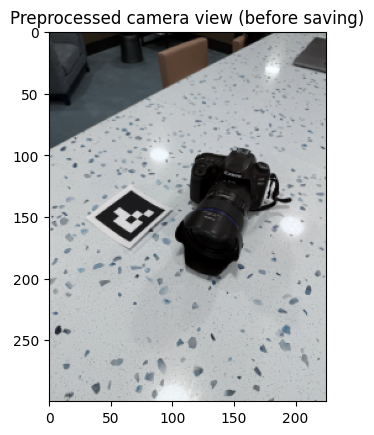

Final dataset image size: 225x300
images_train: (18, 300, 225, 3)
images_val: (3, 300, 225, 3)
c2ws_test: (5, 4, 4)
focal: 14117.3486328125
new_K:
 [[2.68759688e+05 0.00000000e+00 1.12585556e+02]
 [0.00000000e+00 2.68734844e+05 1.50099014e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [32]:
img0 = cv2.imread(image_paths[0])
h0, w0 = img0.shape[:2]

K_np = K.detach().cpu().numpy() if isinstance(K, torch.Tensor) else K
dist_np = dist_coeffs.detach().cpu().numpy() if isinstance(dist_coeffs, torch.Tensor) else dist_coeffs

# compute undistortion intrinsics on original size
new_K, roi = cv2.getOptimalNewCameraMatrix(K_np, dist_np, (w0, h0), alpha=0, newImgSize=(w0, h0))
x, y, w_roi, h_roi = roi

new_K[0, 2] -= x  # cx
new_K[1, 2] -= y  # cy

# scale so long side becomes ~200px
long_side = max(h_roi, w_roi)
target_long = 300.0
scale = target_long / long_side

K_scaled = new_K.copy()
K_scaled[0, 0] *= scale  # fx
K_scaled[1, 1] *= scale  # fy
K_scaled[0, 2] *= scale  # cx
K_scaled[1, 2] *= scale  # cy

focal = float((K_scaled[0, 0] + K_scaled[1, 1]) / 2.0)

new_W = int(round(w_roi * scale))
new_H = int(round(h_roi * scale))

# undistort + crop + resize
undistorted_images = []

for img_path in image_paths:
    img = cv2.imread(img_path)
    undistorted = cv2.undistort(img, K_np, dist_np, None, new_K)
    undistorted = undistorted[y:y + h_roi, x:x + w_roi]
    undistorted_small = cv2.resize(undistorted, (new_W, new_H), interpolation=cv2.INTER_AREA)
    undistorted_small = cv2.cvtColor(undistorted_small, cv2.COLOR_BGR2RGB)
    undistorted_images.append(undistorted_small)

# visualize first image
dbg = undistorted_images[0]
plt.imshow(cv2.cvtColor(dbg, cv2.COLOR_BGR2RGB))
plt.title("Preprocessed camera view (before saving)")
plt.show()

images_all = np.stack(undistorted_images, axis=0)
c2ws_all = np.stack(c2w_mats, axis=0)

N, H, W, _ = images_all.shape
print("Final dataset image size:", f"{W}x{H}")

# split
N_train = int(0.7 * N)
N_val = int(0.15 * N)
N_test = N - N_train - N_val

images_train = images_all[:N_train]
c2ws_train = c2ws_all[:N_train]
images_val = images_all[N_train:N_train + N_val]
c2ws_val = c2ws_all[N_train:N_train + N_val]
c2ws_test = c2ws_all[N_train + N_val:]

# save
np.savez(
    "camera_225x300 (2).npz",
    images_train=images_train,    # (N_train, H, W, 3)
    c2ws_train=c2ws_train,        # (N_train, 4, 4)
    images_val=images_val,        # (N_val, H, W, 3)
    c2ws_val=c2ws_val,            # (N_val, 4, 4)
    c2ws_test=c2ws_test,          # (N_test, 4, 4)
    focal=focal,                  # float
    K=K_scaled.astype(np.float32)
)

print("images_train:", images_train.shape)
print("images_val:", images_val.shape)
print("c2ws_test:", c2ws_test.shape)
print("focal:", focal)
print("new_K:\n", new_K)

# Part 1: Fit a Neural Field to a 2D Image

In [50]:
dev_type = torch.device("mps")  # apple GPU

class PosEnc(nn.Module):
    def __init__(self, L: int):
        super().__init__()
        self.coeff = torch.pow(2, torch.arange(L)) * torch.pi

    def forward(self, x: torch.Tensor):
        coeff = self.coeff.to(x.device)
        t = x.unsqueeze(-1) * coeff
        cos = torch.cos(t).view(*x.shape[:-1], -1)
        sin = torch.sin(t).view(*x.shape[:-1], -1)
        return torch.cat([x, cos, sin], dim=-1)


class MLP(nn.Module):
    def __init__(self, L, hidden_dim, num_hidden_layers):
        super().__init__()

        layers = []
        layers.append(PosEnc(L))
        layers.append(nn.Linear(4 * L + 2, hidden_dim))
        layers.append(nn.ReLU())

        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(hidden_dim, 3))
        layers.append(nn.Sigmoid())

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)


def make_dataloader(img: torch.Tensor, batch_size):
    H, W = img.shape[:2]

    ys, xs = torch.meshgrid(torch.arange(H), torch.arange(W), indexing="ij")
    ys = ys.flatten()
    xs = xs.flatten()

    xy_dataset = torch.stack([ys, xs], dim = 1).float() / torch.tensor([H, W])
    rgb_dataset = img[ys, xs]

    dataset = TensorDataset(xy_dataset, rgb_dataset)
    return DataLoader(dataset, batch_size = batch_size, shuffle = True)


def test(model: nn.Module, img: torch.Tensor):
    H, W = img.shape[:2]

    ys = torch.arange(H, device = dev_type) / H
    xs = torch.arange(W, device = dev_type) / W
    yy, xx = torch.meshgrid(ys, xs, indexing = "ij")

    coords = torch.stack([yy, xx], dim = -1)
    return model(coords)


def psnr(mse_values):
    return 10 * torch.log10(1.0 / mse_values)


def train(model: nn.Module, img: torch.Tensor, n_iter, img_name, log_frequency):
    model.to(dev_type)
    model.train()

    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    dataloader = make_dataloader(img, batch_size=10000)
    data_iter = itertools.cycle(dataloader)

    training_loss, validation_loss = [], []

    for t in range(n_iter):
        X, y = next(data_iter)
        X, y = X.to(dev_type), y.to(dev_type)

        preds = model(X)
        loss = Fn.mse_loss(preds, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if t % log_frequency == 0:
            model.eval()
            with torch.no_grad():
                test_img = test(model, img).cpu()
                valid_loss = Fn.mse_loss(test_img, img)

            print(f"Iteration {t}: train {loss.item()}, valid {valid_loss.item()}")
            training_loss.append(loss.detach())
            validation_loss.append(valid_loss.detach())

            imageio.imwrite(f"../../out/{img_name}_iteration_{t}.jpg", sk.img_as_ubyte(test_img), quality=50)

            model.train()

    return torch.stack(training_loss), torch.stack(validation_loss)

In [9]:
"""
img = cv2.imread("../../img/fox.jpg")[:, :, :3] # drop alpha
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = torch.tensor(img).float() / 255.0

n_iter = 1000
log_freq = 200

training_loss, validation_loss = train(
    MLP(L = 10, hidden_dim = 256, num_hidden_layers = 3),
    img,
    n_iter = n_iter,
    img_name = "fox",
    log_frequency = log_freq
)

x = torch.arange(0, n_iter, log_freq)

plt.plot(x, psnr(validation_loss))
plt.xlabel("Iterations")
plt.ylabel("PSNR")
plt.show()
"""

'\nimg = cv2.imread("../../img/fox.jpg")[:, :, :3] # drop alpha\nimg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)\nimg = torch.tensor(img).float() / 255.0\n\nn_iter = 1000\nlog_freq = 200\n\ntraining_loss, validation_loss = train(\n    MLP(L = 10, hidden_dim = 256, num_hidden_layers = 3),\n    img,\n    n_iter = n_iter,\n    img_name = "fox",\n    log_frequency = log_freq\n)\n\nx = torch.arange(0, n_iter, log_freq)\n\nplt.plot(x, psnr(validation_loss))\nplt.xlabel("Iterations")\nplt.ylabel("PSNR")\nplt.show()\n'

In [10]:
"""
img = cv2.imread("../../img/football.jpg")[:, :, :3] # drop alpha
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = torch.tensor(img).float() / 255.0

n_iter = 2000
log_freq = 200

training_loss, validation_loss = train(
    MLP(L = 10, hidden_dim = 256, num_hidden_layers = 3),
    img,
    n_iter = n_iter,
    img_name = "football",
    log_frequency = log_freq
)

x = torch.arange(0, n_iter, log_freq)

plt.plot(x, psnr(validation_loss))
plt.xlabel("Iterations")
plt.ylabel("PSNR")
plt.show()
"""

'\nimg = cv2.imread("../../img/football.jpg")[:, :, :3] # drop alpha\nimg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)\nimg = torch.tensor(img).float() / 255.0\n\nn_iter = 2000\nlog_freq = 200\n\ntraining_loss, validation_loss = train(\n    MLP(L = 10, hidden_dim = 256, num_hidden_layers = 3),\n    img,\n    n_iter = n_iter,\n    img_name = "football",\n    log_frequency = log_freq\n)\n\nx = torch.arange(0, n_iter, log_freq)\n\nplt.plot(x, psnr(validation_loss))\nplt.xlabel("Iterations")\nplt.ylabel("PSNR")\nplt.show()\n'

Iteration 0: train 0.09857667982578278, valid 0.09758100658655167
Iteration 200: train 0.015415342524647713, valid 0.01471883337944746
Iteration 400: train 0.006392919924110174, valid 0.006528968457132578
Iteration 600: train 0.0049247536808252335, valid 0.005116554908454418
Iteration 800: train 0.0047780475579202175, valid 0.004515711218118668


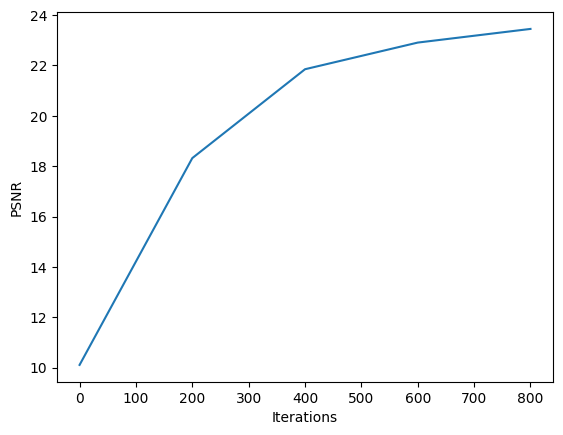

In [51]:
# Show final results for 2 choices of max positional encoding frequency and 2 choices of width (a 2x2 grid of results). Try very low values for these hyperparameters to see how it affects the outputs.

img = cv2.imread("../../img/fox.jpg")[:, :, :3] # drop alpha
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = torch.tensor(img).float() / 255.0

n_iter = 1000
log_freq = 200

training_loss, validation_loss = train(
    MLP(L = 10, hidden_dim = 256, num_hidden_layers = 3),
    img,
    n_iter = n_iter,
    img_name = "fox",
    log_frequency = log_freq
)

x = torch.arange(0, n_iter, log_freq)

plt.plot(x, psnr(validation_loss))
plt.xlabel("Iterations")
plt.ylabel("PSNR")
plt.show()

# Part 2: Fit a Neural Radiance Field from Multi-view Images

In [33]:
"""
data = np.load("lego_200x200.npz")

# Training images: [100, 200, 200, 3]
images_train = data["images_train"] / 255.0

# Cameras for the training images 
# (camera-to-world transformation matrix): [100, 4, 4]
c2ws_train = data["c2ws_train"]

# Validation images: 
images_val = data["images_val"] / 255.0

# Cameras for the validation images: [10, 4, 4]
# (camera-to-world transformation matrix): [10, 200, 200, 3]
c2ws_val = data["c2ws_val"]

# Test cameras for novel-view video rendering: 
# (camera-to-world transformation matrix): [60, 4, 4]
c2ws_test = data["c2ws_test"]

# Camera focal length
focal = float(data["focal"])  # float

H, W = images_train.shape[1:3]
K = torch.Tensor([
    [focal, 0, H / 2],
    [0, focal, W / 2],
    [0, 0, 1]
])
"""

'\ndata = np.load("lego_200x200.npz")\n\n# Training images: [100, 200, 200, 3]\nimages_train = data["images_train"] / 255.0\n\n# Cameras for the training images \n# (camera-to-world transformation matrix): [100, 4, 4]\nc2ws_train = data["c2ws_train"]\n\n# Validation images: \nimages_val = data["images_val"] / 255.0\n\n# Cameras for the validation images: [10, 4, 4]\n# (camera-to-world transformation matrix): [10, 200, 200, 3]\nc2ws_val = data["c2ws_val"]\n\n# Test cameras for novel-view video rendering: \n# (camera-to-world transformation matrix): [60, 4, 4]\nc2ws_test = data["c2ws_test"]\n\n# Camera focal length\nfocal = float(data["focal"])  # float\n\nH, W = images_train.shape[1:3]\nK = torch.Tensor([\n    [focal, 0, H / 2],\n    [0, focal, W / 2],\n    [0, 0, 1]\n])\n'

## Part 2.1: Create Rays from Cameras

In [12]:
def apply_tf(M, pts):
    ones = torch.ones_like(pts[..., :1])
    pts_h = torch.cat([pts, ones], dim=-1).unsqueeze(-1)
    M3 = M[..., :3, :]
    out = M3 @ pts_h
    return out.squeeze(-1)

def uv_to_cam(K_invT, uv):
    ones = torch.ones_like(uv[..., :1])
    uv_h = torch.cat([uv, ones], dim=-1).unsqueeze(-1)
    K_inv = K_invT.T
    x_c = (K_inv @ uv_h).squeeze(-1)
    return x_c

def uv_to_ray(K_invT, c2w, uv):
    B = torch.broadcast_shapes(uv.shape[:-1], c2w.shape[:-2])
    dev = uv.device
    uv_e = uv.expand(*B, 2)
    c2w_e = c2w.expand(*B, 4, 4)
    x_c = uv_to_cam(K_invT, uv_e)
    x_w = apply_tf(c2w_e, x_c)
    o = c2w_e[..., :3, 3]
    d = x_w - o
    d = d / torch.norm(d, dim=-1, keepdim=True)
    return o, d, B, dev

## Part 2.2: Sampling

In [13]:
def sample_random_rays(imgs, K_invT, c2ws, num_samples):
    N, H, W, _ = imgs.shape
    device = imgs.device

    per_img = num_samples // N
    lin_idx = torch.randint(0, H * W, (N, per_img), device=device)
    ys = torch.div(lin_idx, W, rounding_mode="floor")
    xs = lin_idx - ys * W

    cam_tf = c2ws.view(N, 1, 4, 4)
    uv = torch.empty(N, per_img, 2, device=device, dtype=torch.float32)
    uv[..., 0] = xs.to(torch.float32) + 0.5
    uv[..., 1] = ys.to(torch.float32) + 0.5

    rays_o, rays_d, _, _ = uv_to_ray(K_invT, cam_tf, uv)
    img_idx = torch.arange(N, device=device).view(N, 1).expand_as(xs)
    pixels = imgs[img_idx, ys, xs]

    rays_o = rays_o.reshape(-1, 3)
    rays_d = rays_d.reshape(-1, 3)
    pixels = pixels.reshape(-1, 3)
    
    return rays_o, rays_d, pixels


def sample_all_rays(imgs, K_invT, c2ws):
    N, H, W, _ = imgs.shape
    dev = imgs.device

    lin = torch.arange(H * W, device=dev)
    ys = torch.div(lin, W, rounding_mode="floor")
    xs = lin - ys * W

    xs_grid = xs.view(H, W).to(torch.float32) + 0.5
    ys_grid = ys.view(H, W).to(torch.float32) + 0.5

    uv = torch.empty(1, H, W, 2, device=dev, dtype=torch.float32)
    uv[0, ..., 0] = xs_grid
    uv[0, ..., 1] = ys_grid

    cam_tf = c2ws.view(N, 1, 1, 4, 4)
    rays_o, rays_d, _, _ = uv_to_ray(K_invT, cam_tf, uv)
    return rays_o, rays_d, imgs


def sample_along_rays(rays_o, rays_d, near=2.0, far=6.0, num_samples=64, train=False):
    dev = rays_o.device
    B = rays_o.shape[0]

    base = (torch.arange(num_samples, device=dev, dtype=torch.float32) + 0.5) / num_samples
    t_line = near + base * (far - near)

    if train:
        noise = (torch.rand(num_samples, device=dev) - 0.5) * (far - near) / num_samples
        t_line = t_line + noise

    t_vals = t_line.view(1, num_samples, 1).expand(B, num_samples, 1)

    pts = rays_o.unsqueeze(1) + t_vals * rays_d.unsqueeze(1)  # [B, T, 3]
    return pts

## Part 2.3: Putting the Dataloading All Together

In [14]:
class RaysData(object):
    def __init__(self, imgs, K, c2ws, device):
        imgs_t = torch.as_tensor(imgs, dtype=torch.float32)
        K_t = torch.as_tensor(K, dtype=torch.float32)
        c2ws_t = torch.as_tensor(c2ws, dtype=torch.float32)

        # keep a CPU copy of K for stable inverse otherwise errors
        K_cpu = K_t.cpu()
        K_inv_cpu = torch.linalg.inv(K_cpu)
        K_invT_cpu = K_inv_cpu.T

        self.imgs = imgs_t.to(device)
        self.K = K_t.to(device)
        self.K_invT = K_invT_cpu.to(device)
        self.c2ws = c2ws_t.to(device)

        rays_o_full, rays_d_full, imgs_full = sample_all_rays(self.imgs, self.K_invT, self.c2ws)

        N, H, W, _ = imgs_full.shape
        dev = self.imgs.device

        ys = torch.arange(H, device=dev)
        xs = torch.arange(W, device=dev)
        ys_grid, xs_grid = torch.meshgrid(ys, xs, indexing="ij")

        uvs = torch.stack([xs_grid, ys_grid], dim=-1)
        uvs = uvs.unsqueeze(0).expand(N, -1, -1, -1)

        self.uvs = uvs.reshape(-1, 2).cpu().numpy().astype(np.int64)
        # self.pixels = imgs_full.cpu().numpy().reshape(-1, 3)
        self.pixels = np.asarray(imgs).reshape(-1, 3)

        self.rays_o = rays_o_full.reshape(-1, 3)
        self.rays_d = rays_d_full.reshape(-1, 3)

    def sample_random_rays(self, num_samples):
        return sample_random_rays(self.imgs, self.K_invT, self.c2ws, num_samples)

    def sample_all_rays(self):
        return sample_all_rays(self.imgs, self.K_invT, self.c2ws)

In [15]:
"""
# --- You Need to Implement These ------
dataset = RaysData(images_train, K, c2ws_train, dev_type)
rays_o, rays_d, pixels = dataset.sample_random_rays(100) # Should expect (B, 3)
points = sample_along_rays(rays_o, rays_d, train=True)
H, W = images_train.shape[1:3]
# ---------------------------------------

# Move tensors to CPU + NumPy for visualization
rays_o_np = rays_o.detach().cpu().numpy()
rays_d_np = rays_d.detach().cpu().numpy()
points_np = points.detach().cpu().numpy()

server = viser.ViserServer(share=True)
for i, (image, c2w) in enumerate(zip(images_train, c2ws_train)):
    print("adding camera", i, "of", len(images_train))
    server.add_camera_frustum(
        f"/cameras/{i}",
        fov=float(2 * np.arctan2(H / 2.0, focal)),
        aspect=W / H,
        scale=0.15,
        wxyz=viser.transforms.SO3.from_matrix(c2w[:3, :3]).wxyz,
        position=c2w[:3, 3],
        image=image
    )
for i, (o, d) in enumerate(zip(rays_o_np, rays_d_np)):
    server.add_spline_catmull_rom(
        f"/rays/{i}", positions=np.stack((o, o + d * 6.0)),
    )
server.add_point_cloud(
    f"/samples",
    colors=np.zeros_like(points_np).reshape(-1, 3),
    points=points_np.reshape(-1, 3),
    point_size=0.02,
)

while True:
    time.sleep(0.1)  # Wait to allow visualization to run
"""

'\n# --- You Need to Implement These ------\ndataset = RaysData(images_train, K, c2ws_train, dev_type)\nrays_o, rays_d, pixels = dataset.sample_random_rays(100) # Should expect (B, 3)\npoints = sample_along_rays(rays_o, rays_d, train=True)\nH, W = images_train.shape[1:3]\n# ---------------------------------------\n\n# Move tensors to CPU + NumPy for visualization\nrays_o_np = rays_o.detach().cpu().numpy()\nrays_d_np = rays_d.detach().cpu().numpy()\npoints_np = points.detach().cpu().numpy()\n\nserver = viser.ViserServer(share=True)\nfor i, (image, c2w) in enumerate(zip(images_train, c2ws_train)):\n    print("adding camera", i, "of", len(images_train))\n    server.add_camera_frustum(\n        f"/cameras/{i}",\n        fov=float(2 * np.arctan2(H / 2.0, focal)),\n        aspect=W / H,\n        scale=0.15,\n        wxyz=viser.transforms.SO3.from_matrix(c2w[:3, :3]).wxyz,\n        position=c2w[:3, 3],\n        image=image\n    )\nfor i, (o, d) in enumerate(zip(rays_o_np, rays_d_np)):\n    se

In [16]:
"""
# --- You Need to Implement These ------
dataset = RaysData(images_train, K, c2ws_train, dev_type)

# This will check that your uvs aren't flipped
uvs_start = 0
uvs_end = 40_000
sample_uvs = dataset.uvs[uvs_start:uvs_end] # These are integer coordinates of widths / heights (xy not yx) of all the pixels in an image
# uvs are array of xy coordinates, so we need to index into the 0th image tensor with [0, height, width], so we need to index with uv[:,1] and then uv[:,0]
assert np.all(images_train[0, sample_uvs[:,1], sample_uvs[:,0]] == dataset.pixels[uvs_start:uvs_end])

# # Uncoment this to display random rays from the first image
indices = np.random.randint(low=0, high=40_000, size=100)

# # Uncomment this to display random rays from the top left corner of the image
# indices_x = np.random.randint(low=100, high=200, size=100)
# indices_y = np.random.randint(low=0, high=100, size=100)
# indices = indices_x + (indices_y * 200)

data = {"rays_o": dataset.rays_o[indices], "rays_d": dataset.rays_d[indices]}
points = sample_along_rays(data["rays_o"], data["rays_d"], train=True)
# ---------------------------------------

if isinstance(data["rays_o"], torch.Tensor):
    data["rays_o"] = data["rays_o"].detach().cpu().numpy()
if isinstance(data["rays_d"], torch.Tensor):
    data["rays_d"] = data["rays_d"].detach().cpu().numpy()
if isinstance(points, torch.Tensor):
    points = points.detach().cpu().numpy()

server = viser.ViserServer(share=True)
for i, (image, c2w) in enumerate(zip(images_train, c2ws_train)):
  server.add_camera_frustum(
    f"/cameras/{i}",
    fov=float(2 * np.arctan2(H / 2.0, focal)),
    aspect=W / H,
    scale=0.15,
    wxyz=viser.transforms.SO3.from_matrix(c2w[:3, :3]).wxyz,
    position=c2w[:3, 3],
    image=image
  )
for i, (o, d) in enumerate(zip(data["rays_o"], data["rays_d"])):
  positions = np.stack((o, o + d * 6.0))
  server.add_spline_catmull_rom(
      f"/rays/{i}", positions=positions,
  )
server.add_point_cloud(
    f"/samples",
    colors=np.zeros_like(points).reshape(-1, 3),
    points=points.reshape(-1, 3),
    point_size=0.03,
)

while True:
    time.sleep(0.1)  # Wait to allow visualization to run
"""

'\n# --- You Need to Implement These ------\ndataset = RaysData(images_train, K, c2ws_train, dev_type)\n\n# This will check that your uvs aren\'t flipped\nuvs_start = 0\nuvs_end = 40_000\nsample_uvs = dataset.uvs[uvs_start:uvs_end] # These are integer coordinates of widths / heights (xy not yx) of all the pixels in an image\n# uvs are array of xy coordinates, so we need to index into the 0th image tensor with [0, height, width], so we need to index with uv[:,1] and then uv[:,0]\nassert np.all(images_train[0, sample_uvs[:,1], sample_uvs[:,0]] == dataset.pixels[uvs_start:uvs_end])\n\n# # Uncoment this to display random rays from the first image\nindices = np.random.randint(low=0, high=40_000, size=100)\n\n# # Uncomment this to display random rays from the top left corner of the image\n# indices_x = np.random.randint(low=100, high=200, size=100)\n# indices_y = np.random.randint(low=0, high=100, size=100)\n# indices = indices_x + (indices_y * 200)\n\ndata = {"rays_o": dataset.rays_o[indice

## Part 2.4: Neural Radiance Field

In [17]:
class NeRF(nn.Module):
    def __init__(self, L=10, L_r=4):
        super().__init__()

        self.pos_enc_x = PosEnc(L)
        self.pos_enc_dir = PosEnc(L_r)

        x_in_dim = 3 * (2 * L + 1)
        dir_in_dim = 3 * (2 * L_r + 1)
        hidden_dim = 256

        self.x_mlp_1 = nn.Sequential(
            nn.Linear(x_in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )

        self.x_mlp_2 = nn.Sequential(
            nn.Linear(x_in_dim + hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
        )

        # density head
        self.density_head = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.ReLU(),
        )

        # rgb head
        self.rgb_fc = nn.Linear(hidden_dim, hidden_dim)
        self.rgb_mlp = nn.Sequential(
            nn.Linear(dir_in_dim + hidden_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 3),
            nn.Sigmoid(),
        )

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight)
                nn.init.zeros_(module.bias)

        nn.init.constant_(self.density_head[0].bias, 3.0)

    def forward(self, x, ray_dir):
        self.to(x.device)

        x_enc = self.pos_enc_x(x)
        x_feat_1 = self.x_mlp_1(x_enc)

        x_cat = torch.cat([x_enc, x_feat_1], dim=-1)
        x_feat = self.x_mlp_2(x_cat)

        density = self.density_head(x_feat)

        dir_enc = self.pos_enc_dir(ray_dir)

        while dir_enc.ndim < x_feat.ndim:
            dir_enc = dir_enc.unsqueeze(-2)
        dir_enc = dir_enc.expand(*x_feat.shape[:-1], dir_enc.shape[-1])

        rgb_input = torch.cat([dir_enc, self.rgb_fc(x_feat)], dim=-1)
        rgb = self.rgb_mlp(rgb_input)

        return density, rgb

## Part 2.5: Volume Rendering

In [18]:
def volume_rendering(sigma, rgb, step_size):
    density = sigma[..., 0]
    dev = density.device

    alpha = 1.0 - torch.exp(-density * step_size)

    accum = torch.cumsum(density * step_size, dim = -1)
    shifted = torch.cat([torch.zeros_like(accum[..., :1]), accum[..., :-1]], dim = -1)
    trans = torch.exp(-shifted)

    weights = (trans * alpha)[..., None]
    img = torch.sum(weights * rgb, dim = -2)

    return img

In [19]:
def test3d(model, rays_o, rays_d, train, N=64, near=2.0, far=6.0):
    pts = sample_along_rays(rays_o, rays_d, near=near, far=far, num_samples=N, train=train)
    ray_dirs = rays_d.unsqueeze(-2)
    sigma, rgb = model(pts, ray_dirs)
    return volume_rendering(sigma, rgb, (far - near) / N)

In [20]:
def train3d(save_dir, model, start_iter, end_iter, save_freq=50, log_freq=50, sampling_params=(8000, 64, 2.0, 6.0)):
    net = model.to(dev_type)
    opt = optim.AdamW(net.parameters(), lr=5e-4)

    os.makedirs(save_dir, exist_ok=True)

    train_set = RaysData(images_train, K, c2ws_train, dev_type)
    val_set   = RaysData(images_val,   K, c2ws_val,   dev_type)

    val_rays_o_all, val_rays_d_all, _ = val_set.sample_all_rays()

    B, N, near, far = sampling_params
    train_hist, val_hist, rendered_imgs = [], [], []

    it = start_iter
    while it <= end_iter:
        # training
        rays_o, rays_d, target_rgb = train_set.sample_random_rays(B)

        pred_rgb = test3d(net, rays_o, rays_d, train=True, N=N, near=near, far=far)

        loss_val = Fn.mse_loss(pred_rgb, target_rgb)

        opt.zero_grad()
        loss_val.backward()
        opt.step()

        # logging / validation
        if it % log_freq == 0:
            vidx = np.random.randint(len(images_val))

            v_rays_o = val_rays_o_all[vidx].to(dev_type)
            v_rays_d = val_rays_d_all[vidx].to(dev_type)

            with torch.no_grad():
                img_pred = render_img(net, v_rays_o, v_rays_d, N, near, far).cpu()

            img_gt = torch.as_tensor(images_val[vidx], dtype=img_pred.dtype, device=img_pred.device)

            val_val = Fn.mse_loss(img_pred, img_gt)

            print(f"[iter {it}] train_loss={loss_val.item():.6f}, val_loss={val_val.item():.6f}")

            train_hist.append(loss_val.item())
            val_hist.append(val_val.item())
            rendered_imgs.append(img_pred)

            vis_pair = torch.cat([img_pred, img_gt], dim=1).cpu()
            plt.imshow(vis_pair)
            plt.show()

            del val_val
            torch.cuda.empty_cache()

        # checkpoint
        if it % save_freq == 0:
            torch.save(net.state_dict(), f"{save_dir}/model_iteration_{it}.pt")
            torch.save(opt.state_dict(),  f"{save_dir}/optim.pt")

        del loss_val, pred_rgb, target_rgb, rays_o, rays_d
        torch.cuda.empty_cache()

        it += 1

    return torch.tensor(train_hist), torch.tensor(val_hist)

In [21]:
def render_img(model, rays_o, rays_d, N=64, near=2.0, far=6.0, k=3):
    device = rays_o.device
    H, W = rays_o.shape[:2]

    ro = rays_o.contiguous().view(H*W, 3)
    rd = rays_d.contiguous().view(H*W, 3)

    step = (far - near) / float(N)

    pts = sample_along_rays(ro, rd, near=near, far=far, num_samples=N, train=False)

    rd_exp = rd.unsqueeze(-2)

    with torch.no_grad():
        sigma, rgb = model(pts, rd_exp)
        colors_flat = volume_rendering(sigma, rgb, step)
        img = colors_flat.view(H, W, 3)

    return img

In [22]:
def load_model(dir, it):
    model = NeRF().to(dev_type)
    state = torch.load(f'{dir}/model_iteration_{it}.pt', map_location=dev_type)
    model.load_state_dict(state)
    return model

def train_nerf(model_name, iterations, save_freq, log_freq, sampling_params):
    nerf_model = NeRF()
    training_loss, validation_loss = train3d(model_name, nerf_model, 0, iterations, save_freq=save_freq, log_freq=log_freq, sampling_params=sampling_params)
    return training_loss, validation_loss

# render imgs, compute psnr
def eval_checkpoints(out_dir, img_name, model_name, iterations, save_freq, images_val, K, c2ws_val, sampling_params, dev_type):

    val_set = RaysData(images_val, K, c2ws_val, dev_type)
    rays_o_all, rays_d_all, _ = val_set.sample_all_rays()

    B, N, near, far = sampling_params

    val_mse_history = []
    val_target = torch.as_tensor(images_val, dtype=torch.float32, device=dev_type)
    
    for it in range(0, iterations+1, max(save_freq, iterations // 10)):
        print(it)
        
        model = load_model(model_name, it)

        # render
        rays_o0 = rays_o_all[0].to(dev_type)
        rays_d0 = rays_d_all[0].to(dev_type)
        img = render_img(model, rays_o0, rays_d0, N, near, far).cpu()
        imageio.imwrite(os.path.join(out_dir, f"{img_name}_iteration_{it}.jpg"), sk.img_as_ubyte(img.numpy()), quality=100)

        # pnsr
        preds = []
        for i in range(val_target.shape[0]):
            ro = rays_o_all[i].to(dev_type)
            rd = rays_d_all[i].to(dev_type)
            preds.append(render_img(model, ro, rd, N, near, far))
        preds = torch.stack(preds, dim = 0)
    
        diff = preds - val_target
        mse = (diff * diff).mean().item()
        val_mse_history.append(mse)        
    
    val_mse_history = torch.tensor(val_mse_history)
    val_psnr = psnr(val_mse_history)

    return val_psnr

def plot_psnr(iterations, val_pnsr, save_freq):
    it = torch.arange(0, iterations + 1, max(save_freq, iterations // 10))
    plt.plot(it, val_pnsr)
    
    plt.xlabel("Iterations")
    plt.ylabel("PSNR")
    plt.show()

def render_video(out_dir, img_name, model_name, iterations, K, c2ws_test, H, W, sampling_params, dev_type):
    num_views = len(c2ws_test)

    dataset = RaysData(torch.zeros(num_views, H, W, 3), K, c2ws_test, dev_type)
    rays_o_all, rays_d_all, _ = dataset.sample_all_rays()

    B, N, near, far = sampling_params

    model = load_model(model_name, iterations)

    out_path = os.path.join(out_dir, f"{img_name}_iteration_{iterations}.mp4")
    writer = cv2.VideoWriter(out_path, cv2.VideoWriter_fourcc(*"mp4v"), 20, (W, H))

    for idx in range(num_views):
        ro = rays_o_all[idx].to(dev_type)
        rd = rays_d_all[idx].to(dev_type)

        frame = render_img(model, ro, rd, N, near, far).cpu().numpy()
        frame_bgr = sk.img_as_ubyte(frame[:, :, ::-1])

        writer.write(frame_bgr)

    writer.release()

## Train, eval, and render lego dataset

In [23]:
"""
model_name = "model_lego"
img_name = "lego"
out_dir = "../../out/3d_lego/"
iterations = 4000
save_freq = 400
log_freq = 400
sampling_params = (8000, 64, 2.0, 6.0)
"""

'\nmodel_name = "model_lego"\nimg_name = "lego"\nout_dir = "../../out/3d_lego/"\niterations = 4000\nsave_freq = 400\nlog_freq = 400\nsampling_params = (8000, 64, 2.0, 6.0)\n'

In [24]:
"""
# train
training_loss, validation_loss = train_nerf(model_name, iterations, save_freq, log_freq, sampling_params)
"""

'\n# train\ntraining_loss, validation_loss = train_nerf(model_name, iterations, save_freq, log_freq, sampling_params)\n'

In [25]:
"""
# evaluate
val_psnr = eval_checkpoints(out_dir, img_name, model_name, iterations, save_freq, images_val, K, c2ws_val, sampling_params, dev_type)
plot_psnr(iterations, val_psnr, save_freq)
"""

'\n# evaluate\nval_psnr = eval_checkpoints(out_dir, img_name, model_name, iterations, save_freq, images_val, K, c2ws_val, sampling_params, dev_type)\nplot_psnr(iterations, val_psnr, save_freq)\n'

In [26]:
"""
# render video with novel views
render_video(out_dir, img_name, model_name, iterations, K, c2ws_val, H, W, sampling_params, dev_type)
"""

'\n# render video with novel views\nrender_video(out_dir, img_name, model_name, iterations, K, c2ws_val, H, W, sampling_params, dev_type)\n'

## Train, eval, and render camera dataset (my data)

In [41]:
data = np.load("camera_225x300 (2).npz")

# Training images: [100, 200, 200, 3]
images_train = data["images_train"] / 255.0

# Cameras for the training images 
# (camera-to-world transformation matrix): [100, 4, 4]
c2ws_train = data["c2ws_train"]

# Validation images: 
images_val = data["images_val"] / 255.0

# Cameras for the validation images: [10, 4, 4]
# (camera-to-world transformation matrix): [10, 200, 200, 3]
c2ws_val = data["c2ws_val"]

# Test cameras for novel-view video rendering: 
# (camera-to-world transformation matrix): [60, 4, 4]
c2ws_test = data["c2ws_test"]

# Camera focal length
focal = float(data["focal"])  # float

H, W = images_train.shape[1:3]
# K = torch.Tensor([
#     [focal, 0, W / 2],
#     [0, focal, H / 2],
#     [0, 0, 1]
# ])
K = torch.from_numpy(data["K"]).float()

In [42]:
model_name = "model_camera_1"
img_name = "camera"
out_dir = "../../out/3d_camera_1/"
iterations = 10000
save_freq = 500
log_freq = 500
sampling_params = (8000, 64, 2.0, 6.0)

[iter 0] train_loss=0.106777, val_loss=0.081336


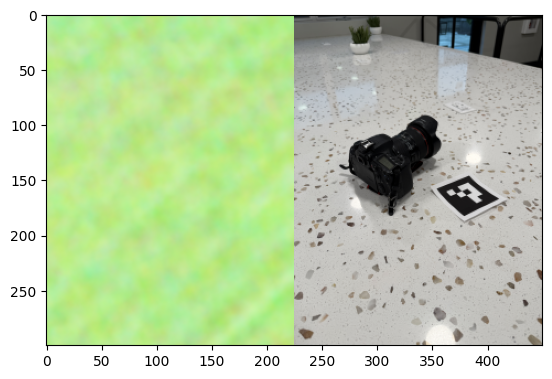

[iter 500] train_loss=0.053614, val_loss=0.048826


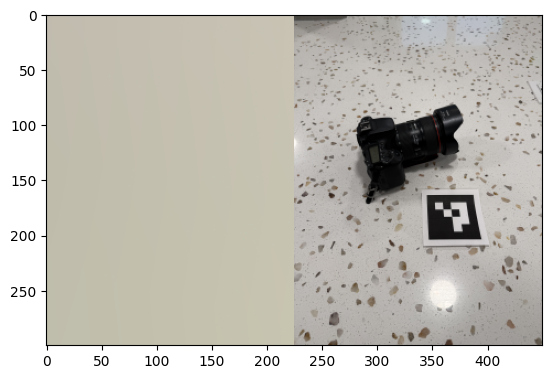

[iter 1000] train_loss=0.157830, val_loss=0.271727


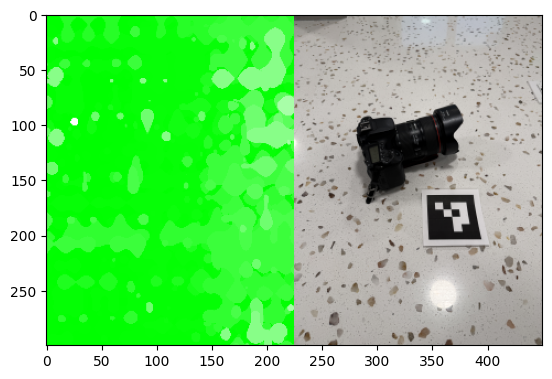

[iter 1500] train_loss=0.193836, val_loss=0.182917


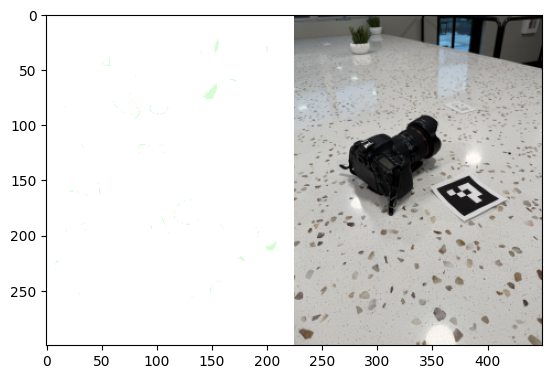

[iter 2000] train_loss=0.189524, val_loss=0.182143


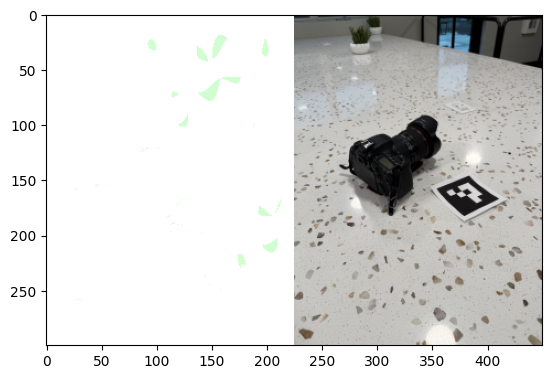

KeyboardInterrupt: 

In [43]:
# train
training_loss, validation_loss = train_nerf(model_name, iterations, save_freq, log_freq, sampling_params)

In [ ]:
# evaluate
val_psnr = eval_checkpoints(out_dir, img_name, model_name, iterations, save_freq, images_val, K, c2ws_val, sampling_params, dev_type)
plot_psnr(iterations, val_psnr, save_freq)

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(training_loss.cpu().numpy())
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss vs Iterations")
plt.grid(True)
plt.show()

In [44]:
model_name = "model_camera_2"
img_name = "camera"
out_dir = "../../out/3d_camera_2/"
iterations = 10000
save_freq = 500
log_freq = 500
sampling_params = (8000, 64, 0.02, 0.5)

[iter 0] train_loss=0.175511, val_loss=0.052085


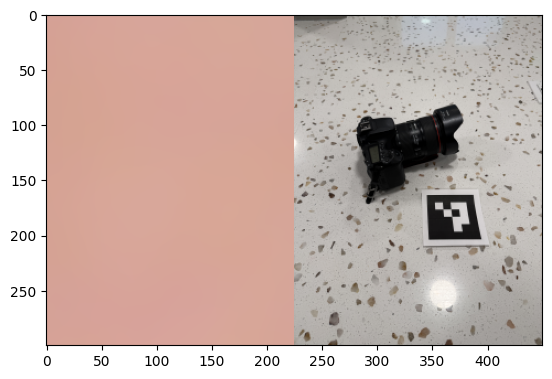

KeyboardInterrupt: 

In [45]:
# train
training_loss_2, validation_loss_2 = train_nerf(model_name, iterations, save_freq, log_freq, sampling_params)

In [ ]:
# evaluate
val_psnr_2 = eval_checkpoints(out_dir, img_name, model_name, iterations, save_freq, images_val, K, c2ws_val, sampling_params, dev_type)
plot_psnr(iterations, val_psnr_2, save_freq)

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(training_loss_2.cpu().numpy())
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss vs Iterations")
plt.grid(True)
plt.show()

In [ ]:
model_name = "model_camera_3"
img_name = "camera"
out_dir = "../../out/3d_camera_3/"
iterations = 10000
save_freq = 500
log_freq = 500
sampling_params = (8000, 64, 0.15, 1.2)

In [ ]:
# train
training_loss_3, validation_loss_3 = train_nerf(model_name, iterations, save_freq, log_freq, sampling_params)

In [ ]:
# evaluate
val_psnr_3 = eval_checkpoints(out_dir, img_name, model_name, iterations, save_freq, images_val, K, c2ws_val, sampling_params, dev_type)
plot_psnr(iterations, val_psnr_3, save_freq)

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(training_loss.cpu().numpy())
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss vs Iterations")
plt.grid(True)
plt.show()

In [ ]:
"""
# render video with novel views
render_video(out_dir, img_name, model_name, iterations, K, c2ws_val, H, W, sampling_params, dev_type)
"""